# Упражнение kNN (k-Nearest Neighbor)

kNN-классификатор состоит из двух этапов:

- Во время обучения классификатор просто запоминает обучающие данные.
- Во время тестирования kNN классифицирует каждое тестовое изображение, сравнивая со всеми обучающими изображениями и передавая метки k наиболее похожих обучающих примеров.
- Значение k кросс-валидируется.

В этом упражнении вы реализуете эти шаги и поймёте основной пайплайн классификации изображений, кросс-валидацию и приобретёте навыки написания эффективного векторизованного кода.

In [1]:
# Запустим установочный код для этого ноутбука.

import os

import numpy as np
import matplotlib.pyplot as plt

from cs231n.data_utils import load_CIFAR10

# Немного магии, позволяющей отображать matplotlib-рисунки в ноутбуке, а не в новом окне.
%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # установим размер графиков по умолчанию
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

# Ещё немного магии, чтобы ноутбук перезагрузил внешние модули Python;
# Смотри http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# Загрузим набор данных CIFAR-10.
cifar10_dir = os.path.join("cs231n", "datasets", "cifar-10-batches-py")

# Очистка переменных для предотвращения многократной загрузки данных (что может вызвать проблемы с памятью).
try:
    del X_train, y_train
    del X_test, y_test
    print("Ранее загруженные данные очищены.")
except:
    pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# В качестве проверки мы распечатываем размер обучающих и тестовых данных.
print("Форма обучающих данных:", X_train.shape)
print("Форма обучающих меток: ", y_train.shape)
print("Форма тестовых данных: ", X_test.shape)
print("Форма тестовых меток:  ", y_test.shape)

Форма обучающих данных: (50000, 32, 32, 3)
Форма обучающих меток:  (50000,)
Форма тестовых данных:  (10000, 32, 32, 3)
Форма тестовых меток:   (10000,)


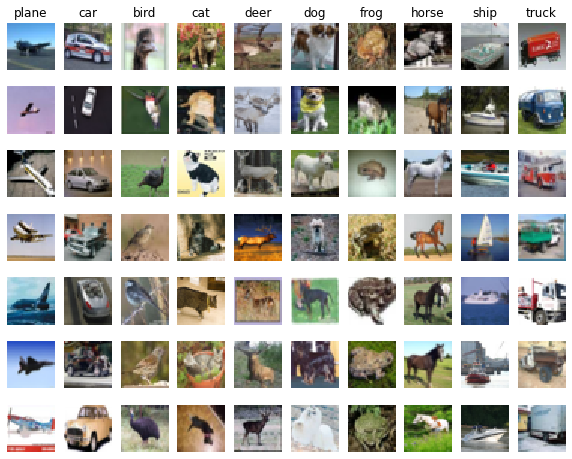

In [3]:
# Визуализируем несколько примеров из набора данных.
# Мы показываем несколько примеров обучающих изображений из каждого класса.
classes = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    rng = np.random.default_rng()
    idxs = rng.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype("uint8"))
        plt.axis("off")
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Подвыборка данных для более эффективного выполнения кода в этом упражнении
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# Предобработка: преобразуем изображения в векторы-строки
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [5]:
from cs231n.classifiers import KNearestNeighbor

# Создадим экземпляр kNN-классификатора.
# Помните, что обучение kNN-классификатора является пустым занятием:
# классификатор просто запоминает данные и не выполняет дальнейшую обработку.  
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

Теперь мы хотели бы классифицировать тестовые данные с помощью kNN-классификатора. Напомним, что мы можем разбить этот процесс на два этапа: 

1. Сначала мы должны вычислить расстояния между всеми тестовыми примерами и всеми обучающими примерами.
2. Учитывая эти расстояния, для каждого тестового примера мы находим k ближайших примеров и заставляем их голосовать за метку.

Начнём с вычисления матрицы расстояний между всеми обучающими и тестовыми примерами. Например, если есть **Ntr** обучающих примеров и **Nte** тестовых примеров, на этом этапе должна получиться матрица **Nte x Ntr**, где каждый (i, j) элемент - это расстояние между i-м тестовым и j-м обучающим примером.

**Примечание: Для трёх вычислений расстояния, которые мы требуем от вас реализовать в этом ноутбуке, нельзя использовать функцию np.linalg.norm(), которую предоставляет numpy.**

Сначала откройте `cs231n/classifiers/k_nearest_neighbor.py` и реализуйте функцию `compute_distances_two_loops`, которая использует (очень неэффективный) двойной цикл по всем парам (test, train) примеров и вычисляет матрицу расстояний по одному элементу за раз.

In [6]:
# Протестируйте свою реализацию:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


Мы можем визуализировать матрицу расстояний: каждая строка представляет собой отдельный тестовый пример и его расстояния до обучающих примеров.

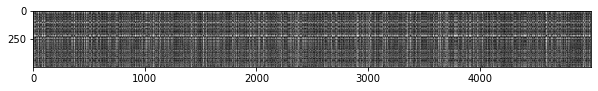

In [7]:
plt.imshow(dists, interpolation="none")
plt.show()

**Вопрос 1** 

Обратите внимание на структурированные паттерны в матрице расстояний, где некоторые строки или столбцы видны ярче. (Обратите внимание, что в цветовой схеме по умолчанию чёрный означает малые расстояния, а белый - большие.)

- Что в данных является причиной отчётливо ярких строк?
- Что вызывает столбцы?

**Мой ответ 1**

- Яркие строки говорят о том, что в тестовых данных есть точки, которые находятся вне сгустка облака обучающих точек.
- Яркие столбцы же говорят об обратном: что в обучающих данных есть точки, которые находятся вне сгустка облака тестовых точек.

Теперь реализуйте функцию `predict_labels` и запустите приведённый ниже код:

In [8]:
# Мы используем k=1 (Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Вычислим и напечатаем долю правильно предсказанных примеров
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print("%d/%d верны => точность: %f" % (num_correct, num_test, accuracy))

137/500 верны => точность: 0.274000


Вы должны ожидать около `27%` точности. Теперь давайте попробуем большее `k`, скажем `k=5`:

In [9]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print("%d/%d верны => точность: %f" % (num_correct, num_test, accuracy))

139/500 верны => точность: 0.278000


Вы должны ожидать немного лучшей производительности, чем при `k=1`.

**Вопрос 2**

Мы также можем использовать другие метрики, такие как L1-расстояние.
Для значений пикселя $p_{ij}^{(k)}$ в позиции $(i,j)$ некоторого изображения $I_k$, 

среднее арифметическое $\mu$ по всем пикселям по всем изображениям $$\mu=\frac{1}{nhw}\sum_{k=1}^n\sum_{i=1}^{h}\sum_{j=1}^{w}p_{ij}^{(k)}$$
А вообще по всем пикселям среднее арифметическое $\mu_{ij}$ по всем изображениям 
$$\mu_{ij}=\frac{1}{n}\sum_{k=1}^np_{ij}^{(k)}.$$
Общее стандартное отклонение $\sigma$ и стандартное отклонение по всем пикселям $\sigma_{ij}$ определяется аналогично.

Какой из следующих шагов предварительной обработки не повлияет на производительность классификатора Nearest Neighbor, который использует L1-расстояние? Выберите всё, что подходит.
1. Вычитание среднего арифметического $\mu$ ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu$).
2. Вычитание попиксельного среднего арифметического $\mu_{ij}$  ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu_{ij}$).
3. Вычитание среднего арифметического $\mu$ и деление на стандартное отклонение $\sigma$.
4. Вычитание попиксельного среднего арифметического $\mu_{ij}$ и деление на попиксельное стандартное отклонение $\sigma_{ij}$.
5. Вращение координатных осей данных.

**Мой ответ 2**

1.
2.
5.

In [10]:
# Теперь давайте ускорим вычисление матрицы расстояний, используя частичную
# векторизацию за один цикл. Реализуйте функцию compute_distances_one_loop
# и запустите приведённый ниже код:
dists_one = classifier.compute_distances_one_loop(X_test)

# Чтобы убедиться, что наша векторизованная реализация верна, мы убеждаемся,
# что она соответствует наивной реализации. Есть много способов определить,
# похожи ли две матрицы; одна из самых простых - это норма Фробениуса. Если
# вы не знакомы с ней, то норма Фробениуса двух матриц - это квадратный
# корень из возведенной в квадрат суммы разностей всех элементов; другими
# словами, преобразовать матрицы в векторы и вычислить евклидово расстояние
# между ними.
difference = np.linalg.norm(dists - dists_one, ord="fro")
print("Разница между реализациями с двумя и одним циклом составила: %f." % difference)
if difference < 0.001:
    print("Отлично! Матрицы расстояний идентичны.")
else:
    print("Ой-ой! Матрицы расстояний разнятся.")

Разница между реализациями с двумя и одним циклом составила: 0.000000.
Отлично! Матрицы расстояний идентичны.


In [11]:
# Теперь реализуйте полностью векторизованную версию внутри
# compute_distances_no_loops и запустите код
dists_two = classifier.compute_distances_no_loops(X_test)

# убедитесь, что матрица расстояний совпадает с той, которую мы вычислили ранее:
difference = np.linalg.norm(dists - dists_two, ord="fro")
print("Разница между реализациями с двумя циклами и без циклов составила: %f." % difference)
if difference < 0.001:
    print("Отлично! Матрицы расстояний идентичны.")
else:
    print("Ой-ой! Матрицы расстояний разнятся.")

Разница между реализациями с двумя циклами и без циклов составила: 0.000000.
Отлично! Матрицы расстояний идентичны.


In [12]:
# Давайте сравним, насколько быстры реализации
def time_function(f, *args):
    """
    Вызвает функцию f с аргументами и ввозвращает время (в секундах), которое потребовалось для выполнения.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print("Реализация с двумя циклами заняла %f секунд." % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print("Реализация с одним циклом заняла %f секунд." % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print("Реализация без циклов заняла %f секунд." % no_loop_time)

# Вы должны увидеть значительно более высокую производительность с полностью
# векторизованной реализацией!

# ПРИМЕЧАНИЕ: В зависимости от того, какую машину вы используете, вы можете
# не увидеть ускорения при переходе от двух циклов к одному и даже можете
# увидеть замедление.

Реализация с двумя циклами заняла 75.688221 секунд.
Реализация с одним циклом заняла 59.629086 секунд.
Реализация без циклов заняла 0.336167 секунд.


### Кросс-валидация

Мы реализовали классификатор k-Nearest Neighbor, но произвольно установили значение k=5. Теперь мы определим наилучшее значение этого гиперпараметра с помощью кросс-валидации.

In [13]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
# ***************************** ЗАДАНИЕ ***************************** #
# Разделите обучающие данные на части. После разделения X_train_folds #
# и y_train_folds должны быть списками длины num_folds, в которых     #
# y_train_folds[i] - вектор меток для точек в X_train_folds[i].       #
#                                                                     #
# ПОДСКАЗКА: Найдите функцию numpy.array_split().                     #

# ************************ НАЧАЛО МОЕГО КОДА ************************ #
# я бы их назвал просто X_folds и y_folds
X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)
# ************************ КОНЕЦ МОЕГО КОДА ************************* #

# Словарь, содержащий точности для различных значений k, которые мы находим при
# выполнении кросс-валидации. После её выполнения k_to_accuracies[k] должен быть
# списком длины num_folds, хранящим различные значения точности, которые мы нашли
# при использовании этого значения k.
k_to_accuracies = {}

# ******************************* ЗАДАНИЕ ******************************* #
# Выполните k-кратную кросс-валидацию, чтобы найти лучшее значение k.     #
# Для каждого возможного значения k запустите алгоритм k-Nearest-Neighbor #
# num_folds раз, и в каждом случае используете все части, кроме одной, в  #
# качестве обучающих данных, а последнюю часть - как валидационную.       #
# Сохраните точности для всех частей и всех значений k в словаре          #
# k_to_accuracies.                                                        #

# ************************** НАЧАЛО МОЕГО КОДА ************************** #
for k in k_choices:
    for i in range(num_folds):
        # создание валидационной части данных
        X_val_part = X_train_folds[i]
        # создание валидационной части меток
        y_val_part = y_train_folds[i]
        # создание списка частей, из которых будет составлена обучающая
        X_new_train_folds = [X_train_folds[j] for j in range(num_folds) if j != i]
        y_new_train_folds = [y_train_folds[j] for j in range(num_folds) if j != i]
        # создание обучающей части данных
        X_train_part = np.concatenate(X_new_train_folds)
        # создание обучающей части меток
        y_train_part = np.concatenate(y_new_train_folds)
        
        # создание экземпляра kNN-классификатора
        classifier = KNearestNeighbor()
        # обучение классификатора
        classifier.train(X_train_part, y_train_part)
        # получение предсказаний
        preds = classifier.predict(X_val_part, k=k)
        
        # подсчёт правильно предсказанных меток
        num_correct = np.sum(preds == y_val_part)
        # расчёт валидационной точности
        accuracy = float(num_correct) / len(y_val_part)
        
        # запись результата
        k_to_accuracies.setdefault(k, []).append(accuracy)
# ************************** КОНЕЦ МОЕГО КОДА *************************** #

# Распечатаем вычисленные точности
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print("k={}, точность = {:2.2%}".format(k, accuracy))

k=1, точность = 0.263000
k=1, точность = 0.257000
k=1, точность = 0.264000
k=1, точность = 0.278000
k=1, точность = 0.266000
k=3, точность = 0.239000
k=3, точность = 0.249000
k=3, точность = 0.240000
k=3, точность = 0.266000
k=3, точность = 0.254000
k=5, точность = 0.248000
k=5, точность = 0.266000
k=5, точность = 0.280000
k=5, точность = 0.292000
k=5, точность = 0.280000
k=8, точность = 0.262000
k=8, точность = 0.282000
k=8, точность = 0.273000
k=8, точность = 0.290000
k=8, точность = 0.273000
k=10, точность = 0.265000
k=10, точность = 0.296000
k=10, точность = 0.276000
k=10, точность = 0.284000
k=10, точность = 0.280000
k=12, точность = 0.260000
k=12, точность = 0.295000
k=12, точность = 0.279000
k=12, точность = 0.283000
k=12, точность = 0.280000
k=15, точность = 0.252000
k=15, точность = 0.289000
k=15, точность = 0.278000
k=15, точность = 0.282000
k=15, точность = 0.274000
k=20, точность = 0.270000
k=20, точность = 0.279000
k=20, точность = 0.279000
k=20, точность = 0.282000
k=20, 

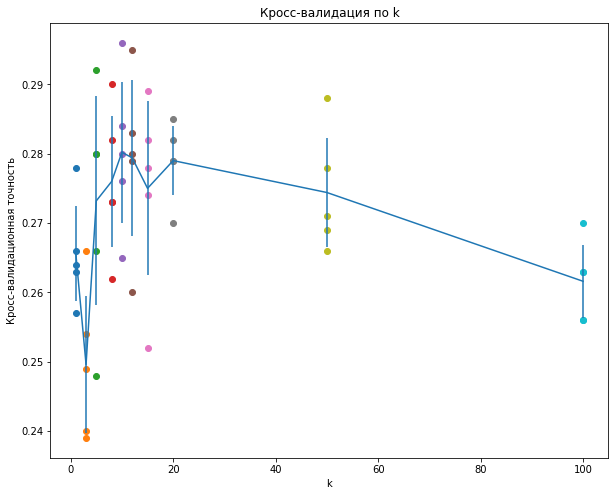

In [14]:
# построим необработанные наблюдения
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# построим линию тренда с полосами ошибок, которые соответствуют стандартному отклонению
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title("Кросс-валидация по k")
plt.xlabel("k")
plt.ylabel("Кросс-валидационная точность")
plt.show()

In [15]:
# Основываясь на результатах кросс-валидации, приведённых выше, выберите лучшее
# значение для k, повторно обучите классификатор, используя все обучающие данные,
# и протестируйте его на тестовых данных. Вы должны получить точность более 28%
# на тестовых данных.
best_k = 6

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Вычислим и отобразим точность
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print("%d/%d верны => точность: %f" % (num_correct, num_test, accuracy))

141/500 верны => точность: 0.282000


**Вопрос 3**

Какие из следующих утверждений о $k$-Nearest Neighbor ($k$-NN) верны в условиях классификации и для всех $k$? Выберите всё, что применимо.
1. Граница принятия решения классификатора k-NN является линейной.
2. Ошибка на обучающих данных 1-NN всегда будет ниже, чем у 5-NN.
3. Ошибка на тестовых данных 1-NN всегда будет ниже, чем у 5-NN.
4. Время, необходимое для классификации тестового примера с помощью классификатора k-NN, увеличивается с увеличением размера обучающего набора.
5. Ни один из вышеперечисленных.

**Мой ответ 3**

2.
4.